## Importing the relevant packages


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.graphics.tsaplots as sgt
from statsmodels.tsa.arima_model import ARMA
from scipy.stats.distributions import chi2
import statsmodels.tsa.stattools as sts 
import seaborn as sns
sns.set()

## Importing the Data and Pre-processing 

In [3]:
raw_csv_data = pd.read_csv("dataset/Index2018.csv") 
df_comp=raw_csv_data.copy()
df_comp.date = pd.to_datetime(df_comp.date, dayfirst = True)
df_comp.set_index("date", inplace=True)
df_comp=df_comp.asfreq('b')
df_comp=df_comp.fillna(method='ffill')

In [4]:
df_comp['market_value']=df_comp.ftse

In [5]:
del df_comp['spx']
del df_comp['dax']
del df_comp['ftse']
del df_comp['nikkei']
size = int(len(df_comp)*0.8)
df, df_test = df_comp.iloc[:size], df_comp.iloc[size:]

## LLR Test

In [6]:
def LLR_test(mod_1, mod_2, DF=1):
    L1 = mod_1.fit().llf
    L2 = mod_2.fit().llf
    LR = (2*(L2-L1))
    p = chi2.sf(LR, DF).round(3)
    return p

## The DF-Test

In [7]:
# p-value = 0.33 > 0.05, rejectm cannot say it's a random walk
sts.adfuller(df.market_value)

(-1.904155141883687,
 0.330108932770283,
 6,
 5014,
 {'1%': -3.4316548765428174,
  '5%': -2.8621166146845334,
  '10%': -2.5670769326348926},
 54854.15304507557)

## Using Returns

In [12]:
# missing value will cause the time series analysis collapse, so you need to remove the first value for %
df['Returns'] = df.market_value.pct_change(1).mul(100)
df = df.iloc[1:]

<ipython-input-12-72101f464e5e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Returns'] = df.market_value.pct_change(1).mul(100)


In [14]:
# returns come from a stationary process
sts.adfuller(df.Returns)

(-12.770265719497221,
 7.798058336038833e-24,
 32,
 4987,
 {'1%': -3.431661944885779,
  '5%': -2.8621197374408225,
  '10%': -2.5670785949998973},
 15696.767245697501)

## ACF and PACF for Returns

Text(0, 0.5, 'correlation')

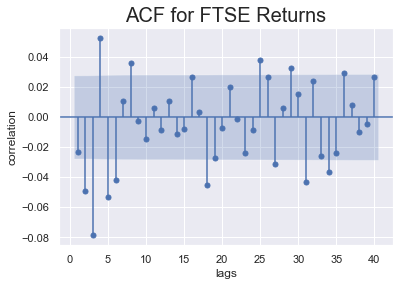

In [15]:
sgt.plot_acf(df.Returns, zero=False, lags=40)
plt.title('ACF for FTSE Returns', size=20)
plt.xlabel('lags')
plt.ylabel('correlation')

In [ ]:
sgt.plot_pacf(df.Returns, zero=False, lags=40, alpha=0.05, method=('ols'))
plt.title('ACF for FTSE', size=20)
plt.xlabel('lags')
plt.ylabel('correlation')

## AR(1) for Returns

## Higher-Lag AR Models for Returns

## Normalizing Values

## Normalized Returns

## Analysing the Residuals